# Modelo clasificador de imágenes
En esta actividad se seleccionó un set de datos de pepsi vs coca cola. En esta actividad se hara el procesado de los datos.

Link del data set utilizado: https://www.kaggle.com/datasets/die9origephit/pepsi-and-cocacola-images. Los datos ya vienen separados entre train y test

Este código está generado con base en el material visto en clase.

Ingresar a la carpeta de drive en la que se estará trabajando

In [ ]:
# Autorizar al archivo a conectarse con google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Accede a la carpeta de drive con la que estamos trabajando y lista su contenido
%cd "/content/drive/MyDrive/Cursos/Tarea 2.2"
!ls

/content/drive/MyDrive/Cursos/Tarea 2.2
augmented		      images	 model2.h5     untitled
ClasificadorDeImagenes.ipynb  model1.h5  modelBase.h5


# Preparación de los datos
Se generan copias de las imagenes en diferentes perspectivas para ampliar el conjunto de datos. Estas transformaciones se generan ya que al tener que identificar Coca colas o Pepsis no es necesario que estas estén en una posición en especifico para  ser reconocidas, por lo que el hecho de que roten o se estiren no afectaría el reconocimiento pero si beneficiaría el entrenamiento.

In [ ]:
# Importamos las librerias
import matplotlib.pyplot as plt
import numpy as np
import os # Nos ayuda a leer los archivos de drive.
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Accedemos a la carpeta donde están las carpetas de test y training
path = "/content/drive/MyDrive/Cursos/Tarea 2.2"

# Accedemos a la carpeta donde están las imagenes
base_dir = 'images'

# Accedemos a las carpetas de train y test
train_dir = os.path.join(base_dir,'train')
test_dir = os.path.join(base_dir, 'test')

# Se hace data augmentation para generar nuevas imagenes
train_datagen = ImageDataGenerator(
							rescale = 1./255,
							rotation_range = 40,
							width_shift_range = 0.4,
							height_shift_range = 0.4,
							shear_range = 0.4,
							zoom_range = 0.4,
							horizontal_flip = True,)

Tomamos imagenes de la carpeta train para entrenar a nuestro modelo.

Found 340 images belonging to 2 classes.


<Figure size 640x480 with 0 Axes>

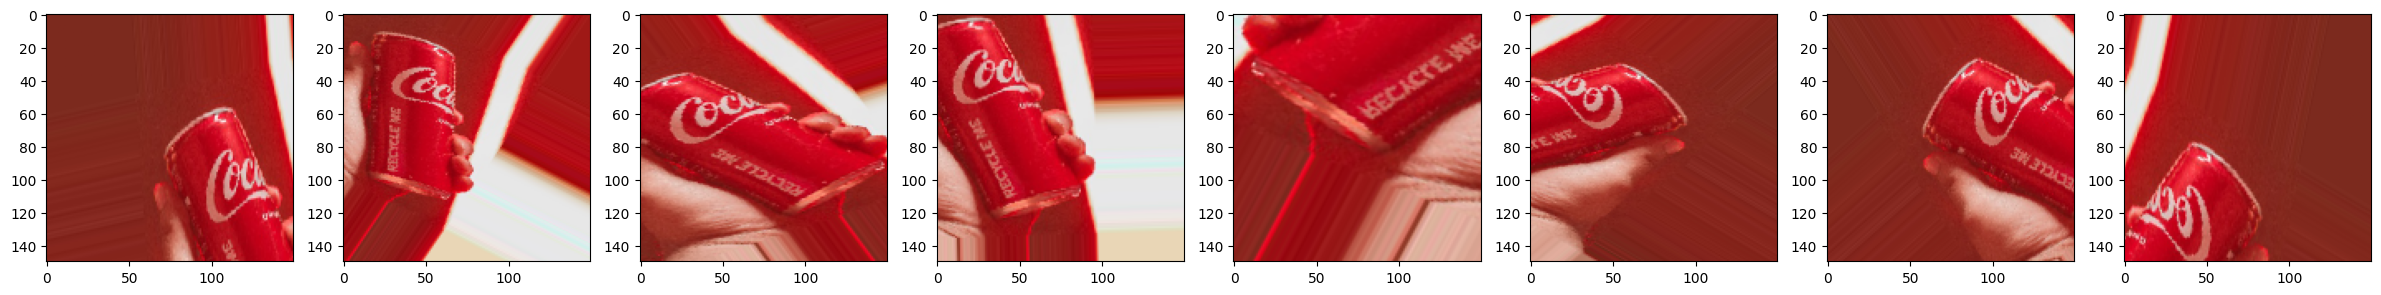

In [ ]:
train_generator = train_datagen.flow_from_directory(
							train_dir,
							target_size = (150, 150),
							batch_size = 8,
							class_mode ='binary', # Usamos binary por que solo tenemmos dos clases
							)


plt.figure()
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1, 8, figsize=(30, 8)) 

for i in range(8) :
  axarr[i].imshow(train_generator[0][0][0])

Se generan las imagenes modificadas en una carpeta llamada *augmented*

In [ ]:
train_generator = train_datagen.flow_from_directory(
							train_dir,
							target_size = (150, 150),
							batch_size = 8,
							class_mode ='binary',
							save_to_dir= path + '/augmented',   
              save_prefix='aug',
              save_format='png'
							)

Found 340 images belonging to 2 classes.



Preparamos las imagenes para el entrenamiento

Found 340 images belonging to 2 classes.
(8, 150, 150, 3)
[0. 1. 0. 0. 0. 0. 1. 0.]


<Figure size 640x480 with 0 Axes>

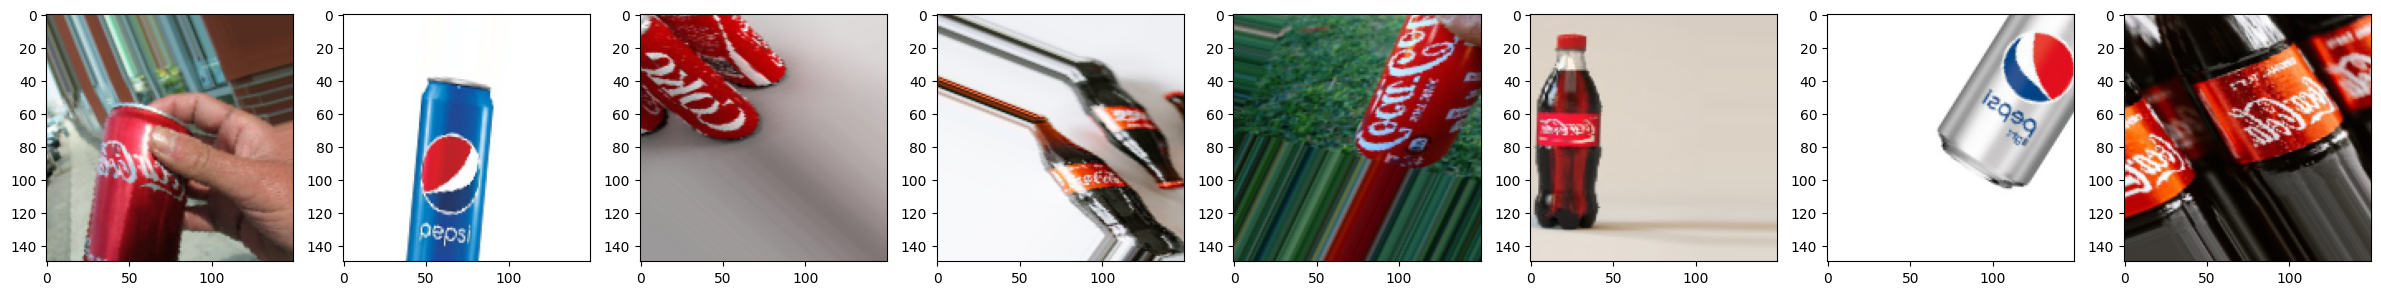

In [ ]:
# Se guardan las imágenes en una variable
train_generator = train_datagen.flow_from_directory(
							train_dir,
							target_size = (150, 150),
							batch_size = 8,
							class_mode ='binary',
							)


images , labels = train_generator[0]

print(images.shape)
print(labels)


plt.figure()
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1, images.shape[0], figsize=(30, 4)) 

for i in range(images.shape[0]) :  
  axarr[i].imshow(images[i])

Se dice que hay que guardar las imagenes en augmented

In [ ]:
train_generator = train_datagen.flow_from_directory(
							train_dir,
							target_size = (150, 150),
							batch_size = 8,
							class_mode ='binary',
							save_to_dir= path + '/augmented',   
              save_prefix='aug',
              save_format='png'
							)

Found 340 images belonging to 2 classes.


# Inicia la red neuronal
## Modelo base
Se genera un modelo que consta de cuatro capas, donde la Dense1 nos ayuda al aprendizaje y la Dense2 clasifica las clases. 

Se usó una CNN ya que estas redes neuronales nos permiten tener un aprendizaje supervizado basado en capas. Se usó un modelo básico planteado en clases

What are Convolutional Neural Networks? | IBM. (2023). Retrieved June 1, 2023, from Ibm.com website: https://www.ibm.com/topics/convolutional-neural-networks

In [ ]:
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers

# Actualmente el modelo tiene 6 capas						
modelBase = models.Sequential()
modelBase.add(layers.Conv2D(10, (3, 3), activation="relu", input_shape = (150,150,3)))
modelBase.add(layers.Flatten())
modelBase.add(layers.Dense(256,activation='relu'))
modelBase.add(layers.Dense(1,activation='sigmoid'))

modelBase.summary()

modelBase.compile(loss='binary_crossentropy',
						optimizer=optimizers.RMSprop(learning_rate=2e-5),
						metrics=['acc'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 148, 148, 10)      280       
                                                                 
 flatten_1 (Flatten)         (None, 219040)            0         
                                                                 
 dense_2 (Dense)             (None, 256)               56074496  
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 56,075,033
Trainable params: 56,075,033
Non-trainable params: 0
_________________________________________________________________


## Generar historial de entrenamiento
Se guardan los datos de perdida y exactitud del modelo, así como el historial de entrenamiento y sus épocas. 

Se entrena el modelo con 10 épocas.

Se generan dos métricas: 

*    Accuracy: refleja la frecuencia de coincidencias entre la predicción y las clases. Team, K. (2023). Keras documentation: Metrics. Retrieved June 1, 2023, from Keras.io website: https://keras.io/api/metrics/

*    Loss: refleja la capacidad de aprendizaje del modelo, mientras más bajo sea indica que el modelo aprende más
Team, K. (2023). Keras documentation: Losses. Retrieved June 1, 2023, from Keras.io website: https://keras.io/api/losses/

‌

‌

Epoch 1/10
43/43 [==============================] - 49s 1s/step - loss: 1.1075 - acc: 0.5706
Epoch 2/10
43/43 [==============================] - 45s 1s/step - loss: 0.9177 - acc: 0.5912
Epoch 3/10
43/43 [==============================] - 56s 1s/step - loss: 0.7882 - acc: 0.6176
Epoch 4/10
43/43 [==============================] - 45s 1s/step - loss: 0.7803 - acc: 0.6471
Epoch 5/10
43/43 [==============================] - 45s 1s/step - loss: 0.7402 - acc: 0.6441
Epoch 6/10
43/43 [==============================] - 45s 1s/step - loss: 0.7949 - acc: 0.6500
Epoch 7/10
43/43 [==============================] - 45s 1s/step - loss: 0.8163 - acc: 0.6059
Epoch 8/10
43/43 [==============================] - 45s 1s/step - loss: 0.6913 - acc: 0.7029
Epoch 9/10
43/43 [==============================] - 45s 1s/step - loss: 0.7414 - acc: 0.6618
Epoch 10/10
43/43 [==============================] - 44s 1s/step - loss: 0.7409 - acc: 0.6647


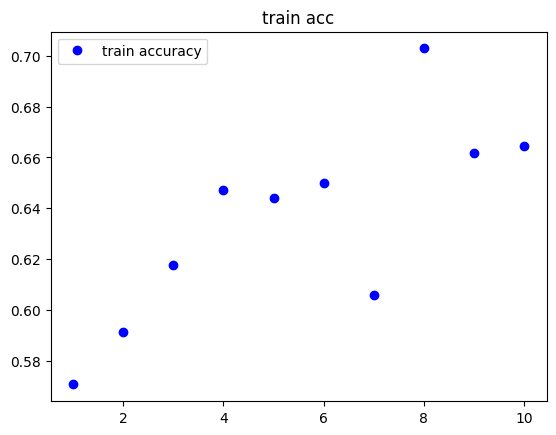

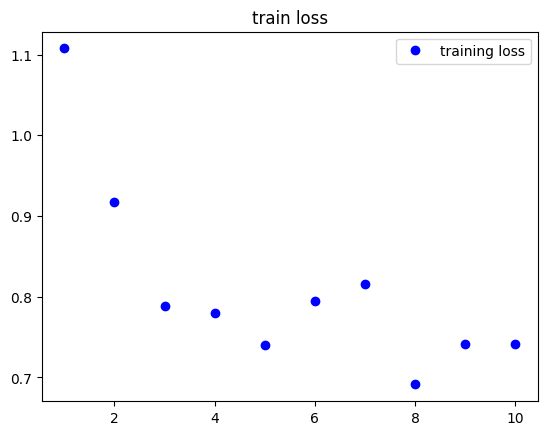

In [ ]:
history = modelBase.fit(
						train_generator, 
						epochs = 10)
				
			
acc = history.history['acc']
loss = history.history['loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs,acc,'bo',label='train accuracy')
plt.title('train acc')
plt.legend()

plt.figure()

plt.plot(epochs,loss, 'bo', label ='training loss')
plt.title('train loss')
plt.legend()

plt.show()

In [ ]:
test_datagen = ImageDataGenerator(1./255)
test_generator = test_datagen.flow_from_directory(
					test_dir,
					target_size = (150, 150),
					batch_size = 20,
					class_mode= 'binary')

test_loss_base, test_acc_base = modelBase.evaluate(test_generator, steps = 25)
print('\ntest acc :\n', test_acc_base)


Found 60 images belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


 3/25 [==>...........................] - ETA: 1:53 - loss: 110.0772 - acc: 0.7500

25/25 [==============================] - 11s 433ms/step - loss: 110.0772 - acc: 0.7500

test acc :
 0.75


## Modelo con más capas
Se genera un modelo que consta de cinco capas, donde la Dense1 y Dense2 nos ayudan al aprendizaje y la Dense3 clasifica las clases

Se usó una CNN ya que estas redes neuronales nos permiten tener un aprendizaje supervizado basado en capas. Se añadió una capa al modelo básico par evaluar como actua el modelo. Esta capa permite que nuestra red presente un mayor aprendizaje.

What are Convolutional Neural Networks? | IBM. (2023). Retrieved June 1, 2023, from Ibm.com website: https://www.ibm.com/topics/convolutional-neural-networks

In [ ]:
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers

# Actualmente el modelo tiene 6 capas						
model1 = models.Sequential()
model1.add(layers.Conv2D(10, (3, 3), activation="relu", input_shape = (150,150,3)))
model1.add(layers.Flatten())
model1.add(layers.Dense(256,activation='relu'))
model1.add(layers.Dense(256,activation='relu'))
model1.add(layers.Dense(1,activation='sigmoid'))

model1.summary()

model1.compile(loss='binary_crossentropy',
						optimizer=optimizers.RMSprop(learning_rate=2e-5),
						metrics=['acc'])


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 148, 148, 10)      280       
                                                                 
 flatten_2 (Flatten)         (None, 219040)            0         
                                                                 
 dense_4 (Dense)             (None, 256)               56074496  
                                                                 
 dense_5 (Dense)             (None, 256)               65792     
                                                                 
 dense_6 (Dense)             (None, 1)                 257       
                                                                 
Total params: 56,140,825
Trainable params: 56,140,825
Non-trainable params: 0
_________________________________________________________________


## Generar historial de entrenamiento
Se guardan los datos de perdida y exactitud del modelo, así como el historial de entrenamiento y sus épocas

Se entrena el modelo con 40 épocas

Se generan dos métricas: 

*    Accuracy: refleja la frecuencia de coincidencias entre la predicción y las clases. Team, K. (2023). Keras documentation: Metrics. Retrieved June 1, 2023, from Keras.io website: https://keras.io/api/metrics/

*    Loss: refleja la capacidad de aprendizaje del modelo, mientras más bajo sea indica que el modelo aprende más
Team, K. (2023). Keras documentation: Losses. Retrieved June 1, 2023, from Keras.io website: https://keras.io/api/losses/

Epoch 1/40
43/43 [==============================] - 58s 1s/step - loss: 0.7344 - acc: 0.5118
Epoch 2/40
43/43 [==============================] - 46s 1s/step - loss: 0.6726 - acc: 0.5735
Epoch 3/40
43/43 [==============================] - 46s 1s/step - loss: 0.6864 - acc: 0.5529
Epoch 4/40
43/43 [==============================] - 46s 1s/step - loss: 0.6637 - acc: 0.6235
Epoch 5/40
43/43 [==============================] - 46s 1s/step - loss: 0.6141 - acc: 0.6471
Epoch 6/40
43/43 [==============================] - 45s 1s/step - loss: 0.6158 - acc: 0.6765
Epoch 7/40
43/43 [==============================] - 46s 1s/step - loss: 0.5837 - acc: 0.7000
Epoch 8/40
43/43 [==============================] - 46s 1s/step - loss: 0.5679 - acc: 0.6882
Epoch 9/40
43/43 [==============================] - 57s 1s/step - loss: 0.5599 - acc: 0.6706
Epoch 10/40
43/43 [==============================] - 46s 1s/step - loss: 0.5434 - acc: 0.6941
Epoch 11/40
43/43 [==============================] - 47s 1s/step - lo

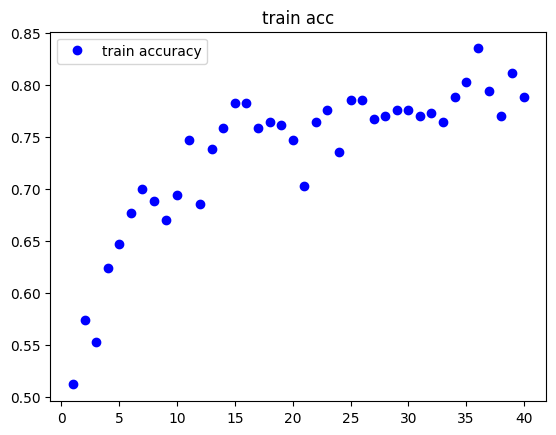

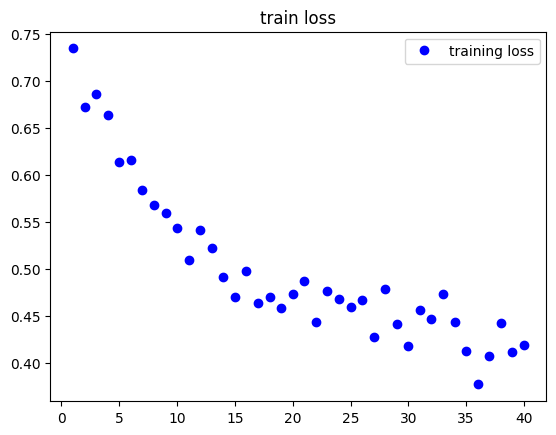

In [ ]:

history = model1.fit(
						train_generator, 
						epochs = 40)
				
			
acc = history.history['acc']
loss = history.history['loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs,acc,'bo',label='train accuracy')
plt.title('train acc')
plt.legend()

plt.figure()

plt.plot(epochs,loss, 'bo', label ='training loss')
plt.title('train loss')
plt.legend()

plt.show()

Se evalúa el modelo. Se obtiene la precisión del modelo.

In [ ]:
test_datagen = ImageDataGenerator(1./255)
test_generator = test_datagen.flow_from_directory(
					test_dir,
					target_size = (150, 150),
					batch_size = 20,
					class_mode= 'binary')

test_loss_capas, test_acc_capas = model1.evaluate(test_generator, steps = 25)
print('\ntest acc :\n', test_acc_capas)


Found 60 images belonging to 2 classes.
 3/25 [==>...........................] - ETA: 6s - loss: 20.8715 - acc: 0.9167

25/25 [==============================] - 1s 25ms/step - loss: 20.8715 - acc: 0.9167

test acc :
 0.9166666865348816


## Modelo vgg
El modelo hace uso de un modelo pre existente llamado vgg16. Esta es una red neuronal convolucional (CNN) con 16 capas. Para obtener información de su uso ingresa al siguiente link. https://keras.io/api/applications/vgg/. 

En adición al modelo vgg se hace uso de 3 capas, donde la Dense1 ayuda al aprendizaje y la Dense2 genera la clasificación de clases.

## Generar historial de entrenamiento
Se guardan los datos de perdida y exactitud del modelo, así como el historial de entrenamiento y sus épocas

Se entrena el modelo con 10 épocas.

Se generan dos métricas: 

*    Accuracy: refleja la frecuencia de coincidencias entre la predicción y las clases. Team, K. (2023). Keras documentation: Metrics. Retrieved June 1, 2023, from Keras.io website: https://keras.io/api/metrics/

*    Loss: refleja la capacidad de aprendizaje del modelo, mientras más bajo sea indica que el modelo aprende más
Team, K. (2023). Keras documentation: Losses. Retrieved June 1, 2023, from Keras.io website: https://keras.io/api/losses/


58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 8192)              0         
                                                                 
 dense_7 (Dense)             (None, 256)               2097408   
                                                                 
 dense_8 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/10
43/43 [==============================] - 89s 2s/step - loss: 0.6742 - acc: 0.5794
Epoch 2/

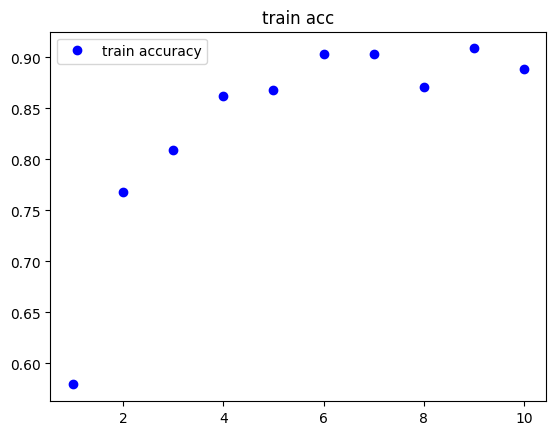

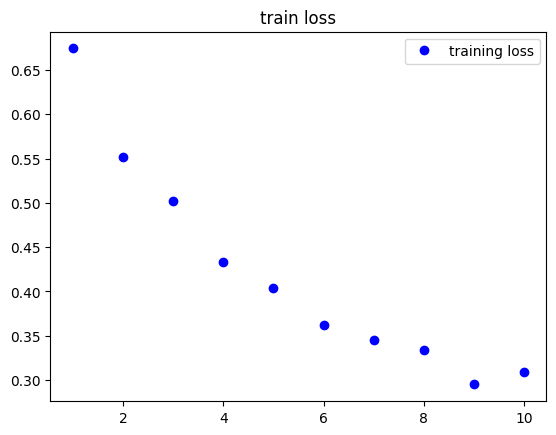

Found 60 images belonging to 2 classes.
 2/25 [=>............................] - ETA: 2:17 - loss: 3.7741 - acc: 0.8833

25/25 [==============================] - 15s 251ms/step - loss: 3.7741 - acc: 0.8833

test acc :
 0.8833333253860474


In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(150,150,3))
base_model.trainable = False ## Not trainable weights
  
model2 = models.Sequential()
model2.add(base_model)
model2.add(layers.Flatten())
model2.add(layers.Dense(256,activation='relu'))
model2.add(layers.Dense(1,activation='sigmoid'))

model2.summary()

model2.compile(loss='binary_crossentropy',
						optimizer = optimizers.RMSprop(learning_rate=2e-5),
						metrics=['acc'])



history = model2.fit(
						train_generator, 
						epochs = 10)
							
acc = history.history['acc']
loss = history.history['loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs,acc,'bo',label='train accuracy')
plt.title('train acc')
plt.legend()

plt.figure()

plt.plot(epochs,loss, 'bo', label ='training loss')
plt.title('train loss')
plt.legend()

plt.show()

test_datagen = ImageDataGenerator(1./255)
test_generator = test_datagen.flow_from_directory(
					test_dir,
					target_size = (150, 150),
					batch_size = 40,
					class_mode= 'binary')

test_loss_vgg, test_acc_vgg = model2.evaluate(test_generator, steps = 25)
print('\ntest acc :\n', test_acc_vgg)

# Comparar resultados
## Perdida y exactitud

In [ ]:
# Recopila los datos de exactitud y perdida de cada modelo
test_loss_base, test_acc_base = modelBase.evaluate(test_generator, steps = 2)
print('\ntest acc :\n', test_acc_base)

test_loss_capas, test_acc_capas = model1.evaluate(test_generator, steps = 2)
print('\ntest acc :\n', test_acc_capas)


test_loss_vgg, test_acc_vgg = model2.evaluate(test_generator, steps = 2)
print('\ntest acc :\n', test_acc_vgg)


2/2 [==============================] - 1s 110ms/step - loss: 110.0772 - acc: 0.7500

test acc :
 0.75
2/2 [==============================] - 1s 112ms/step - loss: 20.8715 - acc: 0.9167

test acc :
 0.9166666865348816
2/2 [==============================] - 15s 4s/step - loss: 3.7741 - acc: 0.8833

test acc :
 0.8833333253860474


### Comparación de resultados
Nos muestra la exactitud y perdida de cada modelo. 

*   El modelo Base es el menos exacto y el que muestra una menor capacidad de aprendizaje. 
*   El modelo con más capas tiene una mayor exactitud y muestra una  capacidad elevada de aprendizaje. 
*   El modelo Transfer VGG es el más eficiente y muestra la mayor capacidad de aprendizaje.  

In [ ]:
print('Model         ', 'test loss            ', ' test accuracy ') 
print('Base      ', test_loss_base, '   ', test_acc_base)
print('Mas capas   ', test_loss_capas, '   ', test_acc_capas)
print('Transfer VGG  ', test_loss_vgg, '  ', test_acc_vgg)

Model          test loss              test accuracy 
Base       110.07719421386719     0.75
Mas capas    20.871532440185547     0.9166666865348816
Transfer VGG   3.7741286754608154    0.8833333253860474


## Gráfica de confusión
Una matriz de confusión nos permite analizar los resultados del aprendizaje de nuestros modelos. Nos muestra de forma gráfica la cantidad de falsos positivos y negativos que se tuvieron en contraste con las imagenes clasificadas correctamente.
### Modelo base
El modelo base nos muestra la existencia de 8 imágenes de Coca Cola que se clasifican como Pepsi 

Este modelo tiene problemas para identificar las imagenes de Coca Cola.

In [ ]:
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

test_imgs = test_generator[0][0]
test_labels = test_generator[0][1]

/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


In [ ]:
predictions = modelBase.predict(test_imgs)
classes_x = predictions.T
classes_x = np.rint(classes_x)

mat = confusion_matrix(classes_x[0], test_labels)
print('\n                ', 'Coca Cola ', ' Pepsi') 
print('pred Coca Cola    ', np.array(mat[0][0]), "        ", np.array(mat[0][1])) 
print('pred Pepsi        ', np.array(mat[1][0]), "         ", np.array(mat[1][1]))

2/2 [==============================] - 1s 115ms/step

                 Coca Cola   Pepsi
pred Coca Cola     20          10
pred Pepsi         0           10


### Modelo con más capas
El modelo base nos muestra la existencia de:
*   1 imagen de Coca Cola que se clasifican como Pepsi
*   1 imagen de Pepsi que se clasifican como Coca Cola

Este modelo nos indica que hay una probabilidad similar en que confunda una Coca Cola o una Pepsi

In [ ]:
predictions = model1.predict(test_imgs)
classes_x = predictions.T
classes_x = np.rint(classes_x)

mat = confusion_matrix(classes_x[0], test_labels)
print('\n                ', 'Coca Cola ', ' Pepsi') 
print('pred Coca Cola     ', np.array(mat[0][0]), "       ", np.array(mat[0][1])) 
print('pred Pepsi         ', np.array(mat[1][0]), "        ", np.array(mat[1][1]))

2/2 [==============================] - 1s 117ms/step

                 Coca Cola   Pepsi
pred Coca Cola      17         0
pred Pepsi          3          20


### Modelo VGG
El modelo base nos muestra la existencia de:

2 imágenes de Pepsi que se clasifican como Coca Cola
Este modelo nos indica que hay una mayor probabilidad de tener dificultades identificando las imágenes de Pepsi

In [ ]:
predictions = model2.predict(test_imgs)
classes_x = predictions.T
classes_x = np.rint(classes_x)

mat = confusion_matrix(classes_x[0], test_labels)
print('\n                ', 'Coca Cola ', ' Pepsi') 
print('pred Coca Cola     ', np.array(mat[0][0]), "       ", np.array(mat[0][1])) 
print('pred Pepsi         ', np.array(mat[1][0]), "        ", np.array(mat[1][1]))

2/2 [==============================] - 9s 2s/step

                 Coca Cola   Pepsi
pred Coca Cola      15         0
pred Pepsi          5          20


## Guardar Modelos


In [ ]:
modelBase.save("modelBase.h5")
model1.save("model1.h5")
model2.save("model2.h5")

# Conclusiones
Los resultados de los modelos anallizados nos muestran que el mejor modelo es el Modelo con más capas, ya que los resultados de las predicciones no se encuentran cargadas hacia ninguna clase, si no que se genera un error equitativo entre ellas. El uso de cada modelo depende de la necesidad que se presente, ya que en el caso de identificar Coca colas y Pepsis por igual, nos sirve el modelo con más capas. En el caso de necesitar identificar mayormente Coca Colas sobre Pepsis  es conveniente el modelo base, ya que la poibilidad de que no se identifique una Coca Cola es menor. Y por último en el caso de necesitar identificar mayoritariamente Pepsis el mejor modelo es el VGG.